In [2]:
from sklearn.datasets import fetch_20newsgroups
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from collections import defaultdict
import gensim
from InitKmeans import InitKmeans
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
     
def pre_processData(newsgroups_train):
    tokenizer = RegexpTokenizer(r'\w+')
    for i in range(len(newsgroups_train)):
        newsgroups_train[i] = newsgroups_train[i].lower()
        #newsgroups_train[i] = tokenizer.tokenize(newsgroups_train[i])
    #newsgroups_train = [[token for token in doc if not token.isdigit()] for doc in newsgroups_train]
    newsgroups_train = [doc.split(' ') for doc in newsgroups_train]
    return newsgroups_train
from sklearn.datasets import fetch_20newsgroups
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from collections import defaultdict
import gensim
from InitKmeans import InitKmeans
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
import sys  
import json
if __name__ == "__main__":
    newsgroups_train = list()
    news_labels = {}
    docID_username = {}
    
    i = 0
    file_path="D:/part_news_biterm.txt"
    with open(file_path) as fp:
        lines = fp.read().split("\n")
        for line in lines:
            if line:
                text = json.loads(line)["bitermText"].strip()
                label = json.loads(line)["clusterNo"]
                newsgroups_train.append(text)
                news_labels[i] = label
                i+=1
    fp.close()
    
    corpus = pre_processData(newsgroups_train)

D:\anacoda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
sum_promote_word_num = 0
for docID in range(len(corpus)):
    words = corpus[docID]
    sum_promote_word_num += len(words) * 2
print(sum_promote_word_num / len(corpus) )
print(sum_promote_word_num / len(corpus) / 2)

36.08749662435863
18.043748312179314


In [3]:
doc_biterm = {}
for docID in range(len(corpus)):
    words = corpus[docID]
    duplicate_biterm = []
    doc_biterm[docID] = {}
    for biterm in words:
        hash_biterm = set(biterm.split(','))
        if hash_biterm not in duplicate_biterm:
            duplicate_biterm.append(hash_biterm)
            doc_biterm[docID][biterm] = 1
        else:
            if biterm in doc_biterm[docID].keys():
                doc_biterm[docID][biterm] += 1
            else:
                doc_biterm[docID][biterm] = 1

In [4]:
doc_words = {}
i_biterm = 0
for docID in range(len(corpus)):
    doc_words[docID] = {}
    words = corpus[docID]
    for biterm in words:
        for word in biterm.split(','):
            if word not in doc_words[docID].keys():
                doc_words[docID][word] = 0
            doc_words[docID][word] += 1

In [34]:
alpha_NMI = {}
alpha_topics = {}
for alpha in np.arange(0.5,5.5,0.5):
    alpha = np.around(alpha,decimals=1)
    docID_assign_z = {}
    m_z = {}
    n_z = {}
    n_w = {}
    n_b = {}
    Topics = []
    V = set()
    D = set()
    #alpha = 1
    beta = 0.02
    total_iter = 10
    for iter in range(total_iter):
        for docID in range(len(corpus)):
            if docID % 1000 == 0:
                print("iter: ",iter," ,docID ",docID)
                print("len(Topics) ",len(Topics))
            words = corpus[docID]
            D.discard(docID)
            if docID in docID_assign_z.keys():
                before_k = docID_assign_z[docID]
                m_z[before_k].discard(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        n_z[before_k][word] -= 1
                        n_w[before_k] -=1
            else:
                before_k = -1
            if len(D) == 0 and len(V) == 0:
                choose_k = 0
                D.add(docID)
                docID_assign_z[docID] = choose_k
                if choose_k not in m_z.keys():
                    m_z[choose_k] = set()
                m_z[choose_k].add(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        if choose_k not in n_w.keys():
                            n_w[choose_k] = 0
                        if choose_k not in n_z.keys():
                            n_z[choose_k] = {}
                        if word not in n_z[choose_k].keys():
                            n_z[choose_k][word] = 0
                        n_z[choose_k][word] += 1
                        n_w[choose_k] += 1
                        V.add(word)
                if choose_k not in Topics:
                    Topics.append(choose_k)
            else:
                log_pro = []
                for k in Topics:
                    pro_k = len(m_z[k])
                    if pro_k != 0:
                        i = 0
                        for biterm in words:
                            each_word = biterm.strip().split(',')
                            for word in each_word:
                                if word not in n_z[k].keys():
                                    n_z[k][word] = 0
                            for j in range(doc_biterm[docID][biterm]):
                                pro_k *= (n_z[k][each_word[0]] + n_z[k][each_word[-1]] + beta + j) / ( n_w[k] + len(V)*beta + i) 
                                i += 1

                    if pro_k == 0:
                        pro_k = sys.float_info.min
                    log_pro.append(pro_k)

                pro_new_k = alpha*(len(D))
                i = 0
                for biterm in words:
                    for j in range(doc_biterm[docID][biterm]):
                        pro_new_k *= ( beta + j) / ( len(V)*beta + i) 
                        i += 1

                if pro_new_k == 0:
                    pro_new_k = sys.float_info.min        
                log_pro.append(pro_new_k)

                sum_pro=sum(log_pro)

                normalized_posterior = [i/sum_pro for i in log_pro]    
                select_k = None
                if iter == (total_iter - 1):
                    select_k = normalized_posterior.index(max(normalized_posterior))

                else:
                    select_k = np.random.choice( (len(Topics)+1) , 1, p=normalized_posterior)[0]  

                if select_k == len(Topics):
                    choose_k = np.max(Topics) + 1
                else:
                    choose_k = Topics[select_k]

                D.add(docID)
                docID_assign_z[docID] = choose_k
                if choose_k not in m_z.keys():
                    m_z[choose_k] = set()
                m_z[choose_k].add(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        if choose_k not in n_w.keys():
                            n_w[choose_k] = 0
                        if choose_k not in n_z.keys():
                            n_z[choose_k] = {}
                        if word not in n_z[choose_k].keys():
                            n_z[choose_k][word] = 0
                        n_z[choose_k][word] += 1
                        n_w[choose_k] += 1
                        V.add(word)
                if choose_k not in Topics:
                    Topics.append(choose_k)

            count_k = []
            for k in Topics:
                if k in m_z.keys() and len(m_z[k]) == 0:
                    m_z.pop(k, None)
                    n_z.pop(k, None)
                    n_w.pop(k, None)
                    count_k.append(k)
            for k in count_k:
                Topics.remove(k)   

        from sklearn.metrics.cluster import normalized_mutual_info_score
        nmi_sample = []
        nmi_result = []
        for key, value in news_labels.items():
                nmi_sample.append(value)
                nmi_result.append(docID_assign_z[key])
        print("alpha ", alpha, "Topics ",len(Topics), " iter ",iter," ",normalized_mutual_info_score(np.array(nmi_sample), np.array(nmi_result)))
        alpha_NMI[alpha] = normalized_mutual_info_score(np.array(nmi_sample), np.array(nmi_result))
        alpha_topics[alpha] = len(Topics)

iter:  0  ,docID  0
len(Topics)  0
iter:  0  ,docID  1000
len(Topics)  59
iter:  0  ,docID  2000
len(Topics)  74
iter:  0  ,docID  3000
len(Topics)  95
iter:  0  ,docID  4000
len(Topics)  106
iter:  0  ,docID  5000
len(Topics)  121
iter:  0  ,docID  6000
len(Topics)  128
iter:  0  ,docID  7000
len(Topics)  141
iter:  0  ,docID  8000
len(Topics)  153
iter:  0  ,docID  9000
len(Topics)  161
iter:  0  ,docID  10000
len(Topics)  170
iter:  0  ,docID  11000
len(Topics)  178
alpha  0.5 Topics  178  iter  0   0.8352707500220937
iter:  1  ,docID  0
len(Topics)  178
iter:  1  ,docID  1000
len(Topics)  175
iter:  1  ,docID  2000
len(Topics)  175
iter:  1  ,docID  3000
len(Topics)  176
iter:  1  ,docID  4000
len(Topics)  179


KeyboardInterrupt: 

In [ ]:
print(alpha_NMI)
print(alpha_topics)

In [10]:
print(alpha_NMI)
print(alpha_topics)

{0.5: 0.870114921716215, 1.0: 0.8788413724305366, 1.5: 0.8797756342655382, 2.0: 0.8887654849390537, 2.5: 0.8880976686846527, 3.0: 0.8858711050400604, 3.5: 0.8848071403531584, 4.0: 0.8845520367144003, 4.5: 0.8878893061951854, 5.0: 0.8848333483794616}
{0.5: 153, 1.0: 185, 1.5: 202, 2.0: 217, 2.5: 222, 3.0: 229, 3.5: 232, 4.0: 237, 4.5: 252, 5.0: 251}


In [35]:
alpha_NMI = {}
alpha_topics = {}
for alpha in np.arange(0.1,1.1,0.1):
    alpha = np.around(alpha,decimals=1)
    docID_assign_z = {}
    m_z = {}
    n_z = {}
    n_w = {}
    n_b = {}
    Topics = []
    V = set()
    D = set()
    #alpha = 1
    beta = 0.02
    total_iter = 10
    for iter in range(total_iter):
        for docID in range(len(corpus)):
            if docID % 1000 == 0:
                print("iter: ",iter," ,docID ",docID)
                print("len(Topics) ",len(Topics))
            words = corpus[docID]
            D.discard(docID)
            if docID in docID_assign_z.keys():
                before_k = docID_assign_z[docID]
                m_z[before_k].discard(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        n_z[before_k][word] -= 1
                        n_w[before_k] -=1
            else:
                before_k = -1
            if len(D) == 0 and len(V) == 0:
                choose_k = 0
                D.add(docID)
                docID_assign_z[docID] = choose_k
                if choose_k not in m_z.keys():
                    m_z[choose_k] = set()
                m_z[choose_k].add(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        if choose_k not in n_w.keys():
                            n_w[choose_k] = 0
                        if choose_k not in n_z.keys():
                            n_z[choose_k] = {}
                        if word not in n_z[choose_k].keys():
                            n_z[choose_k][word] = 0
                        n_z[choose_k][word] += 1
                        n_w[choose_k] += 1
                        V.add(word)
                if choose_k not in Topics:
                    Topics.append(choose_k)
            else:
                log_pro = []
                for k in Topics:
                    pro_k = len(m_z[k])
                    if pro_k != 0:
                        i = 0
                        for biterm in words:
                            each_word = biterm.strip().split(',')
                            for word in each_word:
                                if word not in n_z[k].keys():
                                    n_z[k][word] = 0
                            for j in range(doc_biterm[docID][biterm]):
                                pro_k *= (n_z[k][each_word[0]] + n_z[k][each_word[-1]] + beta + j) / ( n_w[k] + len(V)*beta + i) 
                                i += 1

                    if pro_k == 0:
                        pro_k = sys.float_info.min
                    log_pro.append(pro_k)

                pro_new_k = alpha*(len(D))
                i = 0
                for biterm in words:
                    for j in range(doc_biterm[docID][biterm]):
                        pro_new_k *= ( beta + j) / ( len(V)*beta + i) 
                        i += 1

                if pro_new_k == 0:
                    pro_new_k = sys.float_info.min        
                log_pro.append(pro_new_k)

                sum_pro=sum(log_pro)

                normalized_posterior = [i/sum_pro for i in log_pro]    
                select_k = None
                if iter == (total_iter - 1):
                    select_k = normalized_posterior.index(max(normalized_posterior))

                else:
                    select_k = np.random.choice( (len(Topics)+1) , 1, p=normalized_posterior)[0]  

                if select_k == len(Topics):
                    choose_k = np.max(Topics) + 1
                else:
                    choose_k = Topics[select_k]

                D.add(docID)
                docID_assign_z[docID] = choose_k
                if choose_k not in m_z.keys():
                    m_z[choose_k] = set()
                m_z[choose_k].add(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        if choose_k not in n_w.keys():
                            n_w[choose_k] = 0
                        if choose_k not in n_z.keys():
                            n_z[choose_k] = {}
                        if word not in n_z[choose_k].keys():
                            n_z[choose_k][word] = 0
                        n_z[choose_k][word] += 1
                        n_w[choose_k] += 1
                        V.add(word)
                if choose_k not in Topics:
                    Topics.append(choose_k)

            count_k = []
            for k in Topics:
                if k in m_z.keys() and len(m_z[k]) == 0:
                    m_z.pop(k, None)
                    n_z.pop(k, None)
                    n_w.pop(k, None)
                    count_k.append(k)
            for k in count_k:
                Topics.remove(k)   

        from sklearn.metrics.cluster import normalized_mutual_info_score
        nmi_sample = []
        nmi_result = []
        for key, value in news_labels.items():
                nmi_sample.append(value)
                nmi_result.append(docID_assign_z[key])
        print("alpha ", alpha, "Topics ",len(Topics), " iter ",iter," ",normalized_mutual_info_score(np.array(nmi_sample), np.array(nmi_result)))
        alpha_NMI[alpha] = normalized_mutual_info_score(np.array(nmi_sample), np.array(nmi_result))
        alpha_topics[alpha] = len(Topics)

iter:  0  ,docID  0
len(Topics)  0
iter:  0  ,docID  1000
len(Topics)  53
iter:  0  ,docID  2000
len(Topics)  65
iter:  0  ,docID  3000
len(Topics)  79
iter:  0  ,docID  4000
len(Topics)  90
iter:  0  ,docID  5000
len(Topics)  100
iter:  0  ,docID  6000
len(Topics)  108
iter:  0  ,docID  7000
len(Topics)  121
iter:  0  ,docID  8000
len(Topics)  127
iter:  0  ,docID  9000
len(Topics)  136
iter:  0  ,docID  10000
len(Topics)  150
iter:  0  ,docID  11000
len(Topics)  154
alpha  0.1 Topics  155  iter  0   0.8165862363055336
iter:  1  ,docID  0
len(Topics)  155
iter:  1  ,docID  1000
len(Topics)  152
iter:  1  ,docID  2000
len(Topics)  151
iter:  1  ,docID  3000
len(Topics)  153
iter:  1  ,docID  4000
len(Topics)  155
iter:  1  ,docID  5000
len(Topics)  155
iter:  1  ,docID  6000
len(Topics)  155
iter:  1  ,docID  7000
len(Topics)  152
iter:  1  ,docID  8000
len(Topics)  149
iter:  1  ,docID  9000
len(Topics)  147
iter:  1  ,docID  10000
len(Topics)  147
iter:  1  ,docID  11000
len(Topics) 

iter:  5  ,docID  6000
len(Topics)  152
iter:  5  ,docID  7000
len(Topics)  149
iter:  5  ,docID  8000
len(Topics)  150
iter:  5  ,docID  9000
len(Topics)  150
iter:  5  ,docID  10000
len(Topics)  152
iter:  5  ,docID  11000
len(Topics)  152
alpha  0.2 Topics  153  iter  5   0.8811085589285266
iter:  6  ,docID  0
len(Topics)  153
iter:  6  ,docID  1000
len(Topics)  154
iter:  6  ,docID  2000
len(Topics)  154
iter:  6  ,docID  3000
len(Topics)  153
iter:  6  ,docID  4000
len(Topics)  155
iter:  6  ,docID  5000
len(Topics)  153
iter:  6  ,docID  6000
len(Topics)  153
iter:  6  ,docID  7000
len(Topics)  158
iter:  6  ,docID  8000
len(Topics)  156
iter:  6  ,docID  9000
len(Topics)  158
iter:  6  ,docID  10000
len(Topics)  157
iter:  6  ,docID  11000
len(Topics)  159
alpha  0.2 Topics  157  iter  6   0.8820811928508472
iter:  7  ,docID  0
len(Topics)  157
iter:  7  ,docID  1000
len(Topics)  158
iter:  7  ,docID  2000
len(Topics)  159
iter:  7  ,docID  3000
len(Topics)  160
iter:  7  ,docID

alpha  0.4 Topics  177  iter  0   0.8260880806957916
iter:  1  ,docID  0
len(Topics)  177
iter:  1  ,docID  1000
len(Topics)  176
iter:  1  ,docID  2000
len(Topics)  176
iter:  1  ,docID  3000
len(Topics)  174
iter:  1  ,docID  4000
len(Topics)  176
iter:  1  ,docID  5000
len(Topics)  172
iter:  1  ,docID  6000
len(Topics)  174
iter:  1  ,docID  7000
len(Topics)  172
iter:  1  ,docID  8000
len(Topics)  164
iter:  1  ,docID  9000
len(Topics)  163
iter:  1  ,docID  10000
len(Topics)  165
iter:  1  ,docID  11000
len(Topics)  161
alpha  0.4 Topics  161  iter  1   0.8615668034778667
iter:  2  ,docID  0
len(Topics)  161
iter:  2  ,docID  1000
len(Topics)  161
iter:  2  ,docID  2000
len(Topics)  161
iter:  2  ,docID  3000
len(Topics)  161
iter:  2  ,docID  4000
len(Topics)  161
iter:  2  ,docID  5000
len(Topics)  162
iter:  2  ,docID  6000
len(Topics)  162
iter:  2  ,docID  7000
len(Topics)  164
iter:  2  ,docID  8000
len(Topics)  165
iter:  2  ,docID  9000
len(Topics)  164
iter:  2  ,docID  

iter:  6  ,docID  5000
len(Topics)  180
iter:  6  ,docID  6000
len(Topics)  180
iter:  6  ,docID  7000
len(Topics)  179
iter:  6  ,docID  8000
len(Topics)  182
iter:  6  ,docID  9000
len(Topics)  182
iter:  6  ,docID  10000
len(Topics)  182
iter:  6  ,docID  11000
len(Topics)  183
alpha  0.5 Topics  184  iter  6   0.8704035313754311
iter:  7  ,docID  0
len(Topics)  184
iter:  7  ,docID  1000
len(Topics)  183
iter:  7  ,docID  2000
len(Topics)  183
iter:  7  ,docID  3000
len(Topics)  182
iter:  7  ,docID  4000
len(Topics)  183
iter:  7  ,docID  5000
len(Topics)  183
iter:  7  ,docID  6000
len(Topics)  181
iter:  7  ,docID  7000
len(Topics)  182
iter:  7  ,docID  8000
len(Topics)  182
iter:  7  ,docID  9000
len(Topics)  182
iter:  7  ,docID  10000
len(Topics)  183
iter:  7  ,docID  11000
len(Topics)  186
alpha  0.5 Topics  186  iter  7   0.8723110575443074
iter:  8  ,docID  0
len(Topics)  186
iter:  8  ,docID  1000
len(Topics)  186
iter:  8  ,docID  2000
len(Topics)  186
iter:  8  ,docID

iter:  1  ,docID  11000
len(Topics)  186
alpha  0.7 Topics  186  iter  1   0.8622084652822479
iter:  2  ,docID  0
len(Topics)  186
iter:  2  ,docID  1000
len(Topics)  184
iter:  2  ,docID  2000
len(Topics)  186
iter:  2  ,docID  3000
len(Topics)  185
iter:  2  ,docID  4000
len(Topics)  183
iter:  2  ,docID  5000
len(Topics)  181
iter:  2  ,docID  6000
len(Topics)  181
iter:  2  ,docID  7000
len(Topics)  182
iter:  2  ,docID  8000
len(Topics)  183
iter:  2  ,docID  9000
len(Topics)  181
iter:  2  ,docID  10000
len(Topics)  182
iter:  2  ,docID  11000
len(Topics)  182
alpha  0.7 Topics  183  iter  2   0.8688325303158868
iter:  3  ,docID  0
len(Topics)  183
iter:  3  ,docID  1000
len(Topics)  183
iter:  3  ,docID  2000
len(Topics)  184
iter:  3  ,docID  3000
len(Topics)  187
iter:  3  ,docID  4000
len(Topics)  192
iter:  3  ,docID  5000
len(Topics)  193
iter:  3  ,docID  6000
len(Topics)  193
iter:  3  ,docID  7000
len(Topics)  192
iter:  3  ,docID  8000
len(Topics)  189
iter:  3  ,docID 

iter:  7  ,docID  4000
len(Topics)  194
iter:  7  ,docID  5000
len(Topics)  193
iter:  7  ,docID  6000
len(Topics)  196
iter:  7  ,docID  7000
len(Topics)  198
iter:  7  ,docID  8000
len(Topics)  196
iter:  7  ,docID  9000
len(Topics)  198
iter:  7  ,docID  10000
len(Topics)  198
iter:  7  ,docID  11000
len(Topics)  196
alpha  0.8 Topics  196  iter  7   0.8804672171154052
iter:  8  ,docID  0
len(Topics)  196
iter:  8  ,docID  1000
len(Topics)  195
iter:  8  ,docID  2000
len(Topics)  195
iter:  8  ,docID  3000
len(Topics)  195
iter:  8  ,docID  4000
len(Topics)  195
iter:  8  ,docID  5000
len(Topics)  194
iter:  8  ,docID  6000
len(Topics)  193
iter:  8  ,docID  7000
len(Topics)  190
iter:  8  ,docID  8000
len(Topics)  192
iter:  8  ,docID  9000
len(Topics)  192
iter:  8  ,docID  10000
len(Topics)  191
iter:  8  ,docID  11000
len(Topics)  193
alpha  0.8 Topics  194  iter  8   0.8810604113550632
iter:  9  ,docID  0
len(Topics)  194
iter:  9  ,docID  1000
len(Topics)  196
iter:  9  ,docID

iter:  2  ,docID  10000
len(Topics)  207
iter:  2  ,docID  11000
len(Topics)  200
alpha  1.0 Topics  199  iter  2   0.8655532633920713
iter:  3  ,docID  0
len(Topics)  199
iter:  3  ,docID  1000
len(Topics)  197
iter:  3  ,docID  2000
len(Topics)  197
iter:  3  ,docID  3000
len(Topics)  195
iter:  3  ,docID  4000
len(Topics)  193
iter:  3  ,docID  5000
len(Topics)  193
iter:  3  ,docID  6000
len(Topics)  194
iter:  3  ,docID  7000
len(Topics)  196
iter:  3  ,docID  8000
len(Topics)  194
iter:  3  ,docID  9000
len(Topics)  193
iter:  3  ,docID  10000
len(Topics)  195
iter:  3  ,docID  11000
len(Topics)  197
alpha  1.0 Topics  198  iter  3   0.8706790390935448
iter:  4  ,docID  0
len(Topics)  198
iter:  4  ,docID  1000
len(Topics)  198
iter:  4  ,docID  2000
len(Topics)  199
iter:  4  ,docID  3000
len(Topics)  201
iter:  4  ,docID  4000
len(Topics)  201
iter:  4  ,docID  5000
len(Topics)  199
iter:  4  ,docID  6000
len(Topics)  199
iter:  4  ,docID  7000
len(Topics)  203
iter:  4  ,docID

In [36]:
print(alpha_NMI.values())
print(alpha_NMI.keys())

dict_values([0.8803444875293934, 0.8883167690001632, 0.8843174981032071, 0.8836707238842227, 0.8765261158983819, 0.8802037483339297, 0.8899148720736353, 0.8851528627631094, 0.8842025406456431, 0.880918049619418])
dict_keys([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])


In [37]:
print(alpha_topics.values())
print(alpha_topics.keys())

dict_values([139, 149, 157, 165, 183, 183, 193, 193, 198, 207])
dict_keys([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])


In [17]:
print(alpha_NMI.values())
print(alpha_NMI.keys())

dict_values([0.8701064628011743, 0.8791220703267416, 0.8784863576750682, 0.8802691926562725, 0.8858562158225184, 0.8830048633869253, 0.8762745445213965, 0.8803015348929788, 0.8788164693242252, 0.884131464209089])
dict_keys([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])


In [5]:
import timeit
total_batch = 16
NMI_batch = {}
start = 0
end = 0
topic_batch = {}
time_iteration_list = []
for batch_i in range(1,17):
    if batch_i == 16:
        end = int(len(corpus))
    else:
        end = int(len(corpus) / total_batch) * batch_i
    
    docID_assign_z = {}
    m_z = {}
    n_z = {}
    n_w = {}
    n_b = {}
    Topics = []
    V = set()
    D = set()
    alpha = 0.6
    beta = 0.02
    NMI_batch[batch_i] = 0
    topic_batch[batch_i] = 0
    
    time_start = timeit.default_timer()
    total_iter = 10
    for iter in range(total_iter):
        for docID in range(start,end):
            words = corpus[docID]
            D.discard(docID)
            if docID in docID_assign_z.keys():
                before_k = docID_assign_z[docID]
                m_z[before_k].discard(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        n_z[before_k][word] -= 1
                        n_w[before_k] -=1
            else:
                before_k = -1
            if len(D) == 0 and len(V) == 0:
                choose_k = 0
                D.add(docID)
                docID_assign_z[docID] = choose_k
                if choose_k not in m_z.keys():
                    m_z[choose_k] = set()
                m_z[choose_k].add(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        if choose_k not in n_w.keys():
                            n_w[choose_k] = 0
                        if choose_k not in n_z.keys():
                            n_z[choose_k] = {}
                        if word not in n_z[choose_k].keys():
                            n_z[choose_k][word] = 0
                        n_z[choose_k][word] += 1
                        n_w[choose_k] += 1
                        V.add(word)
                if choose_k not in Topics:
                    Topics.append(choose_k)
            else:
                log_pro = []
                for k in Topics:
                    pro_k = len(m_z[k])
                    if pro_k != 0:
                        i = 0
                        for biterm in words:
                            each_word = biterm.strip().split(',')
                            for word in each_word:
                                if word not in n_z[k].keys():
                                    n_z[k][word] = 0
                            for j in range(doc_biterm[docID][biterm]):
                                pro_k *= (n_z[k][each_word[0]] + n_z[k][each_word[-1]] + beta + j) / ( n_w[k] + len(V)*beta + i) 
                                i += 1

                    if pro_k == 0:
                        pro_k = sys.float_info.min
                    log_pro.append(pro_k)

                pro_new_k = alpha*(len(D))
                i = 0
                for biterm in words:
                    for j in range(doc_biterm[docID][biterm]):
                        pro_new_k *= ( beta + j) / ( len(V)*beta + i) 
                        i += 1

                if pro_new_k == 0:
                    pro_new_k = sys.float_info.min        
                log_pro.append(pro_new_k)

                sum_pro=sum(log_pro)

                normalized_posterior = [i/sum_pro for i in log_pro]    
                select_k = None
                if iter == (total_iter - 1):
                    select_k = normalized_posterior.index(max(normalized_posterior))

                else:
                    select_k = np.random.choice( (len(Topics)+1) , 1, p=normalized_posterior)[0]  

                if select_k == len(Topics):
                    choose_k = np.max(Topics) + 1
                else:
                    choose_k = Topics[select_k]

                D.add(docID)
                docID_assign_z[docID] = choose_k
                if choose_k not in m_z.keys():
                    m_z[choose_k] = set()
                m_z[choose_k].add(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        if choose_k not in n_w.keys():
                            n_w[choose_k] = 0
                        if choose_k not in n_z.keys():
                            n_z[choose_k] = {}
                        if word not in n_z[choose_k].keys():
                            n_z[choose_k][word] = 0
                        n_z[choose_k][word] += 1
                        n_w[choose_k] += 1
                        V.add(word)
                if choose_k not in Topics:
                    Topics.append(choose_k)

            count_k = []
            for k in Topics:
                if k in m_z.keys() and len(m_z[k]) == 0:
                    m_z.pop(k, None)
                    n_z.pop(k, None)
                    n_w.pop(k, None)
                    count_k.append(k)
            for k in count_k:
                Topics.remove(k)   
        if iter == 9:
            from sklearn.metrics.cluster import normalized_mutual_info_score
            nmi_sample = []
            nmi_result = []
            for key, value in news_labels.items():
                if key < end and key >= start:
                    nmi_sample.append(value)
                    nmi_result.append(docID_assign_z[key])
            NMI_batch[batch_i] = normalized_mutual_info_score(np.array(nmi_sample), np.array(nmi_result))
            topic_batch[batch_i] = len(Topics)
            print("start ",start, " end ",end, "topics: ",len(Topics),"truth: ",len(np.unique(nmi_sample)), " NMI: ",normalized_mutual_info_score(np.array(nmi_sample), np.array(nmi_result)))
#     if batch_i != 1:
#         start = int(len(corpus) / total_batch) * (batch_i -1) + 1
    time_stop = timeit.default_timer()
    time_iteration_list.append(time_stop-time_start)
    print(time_iteration_list)

start  0  end  694 topics:  36 truth:  7  NMI:  0.797919276049557
[9.275168720923979]
start  0  end  1388 topics:  61 truth:  14  NMI:  0.834373909869214
[9.275168720923979, 27.47660983092903]
start  0  end  2082 topics:  72 truth:  21  NMI:  0.8748294287905843
[9.275168720923979, 27.47660983092903, 50.720040298918704]
start  0  end  2776 topics:  80 truth:  29  NMI:  0.8713164902154632
[9.275168720923979, 27.47660983092903, 50.720040298918704, 77.95182308137694]
start  0  end  3470 topics:  101 truth:  42  NMI:  0.8580728556019709
[9.275168720923979, 27.47660983092903, 50.720040298918704, 77.95182308137694, 157.289227671163]
start  0  end  4164 topics:  104 truth:  48  NMI:  0.8725166132613533
[9.275168720923979, 27.47660983092903, 50.720040298918704, 77.95182308137694, 157.289227671163, 203.79968294498195]
start  0  end  4858 topics:  107 truth:  61  NMI:  0.88360313629789
[9.275168720923979, 27.47660983092903, 50.720040298918704, 77.95182308137694, 157.289227671163, 203.799682944981

In [28]:
print(topic_batch.keys())

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])


In [30]:
print(topic_batch.keys())
print(topic_batch.values())

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
dict_values([36, 61, 72, 80, 101, 104, 107, 113, 122, 135, 141, 146, 155, 167, 175, 182])


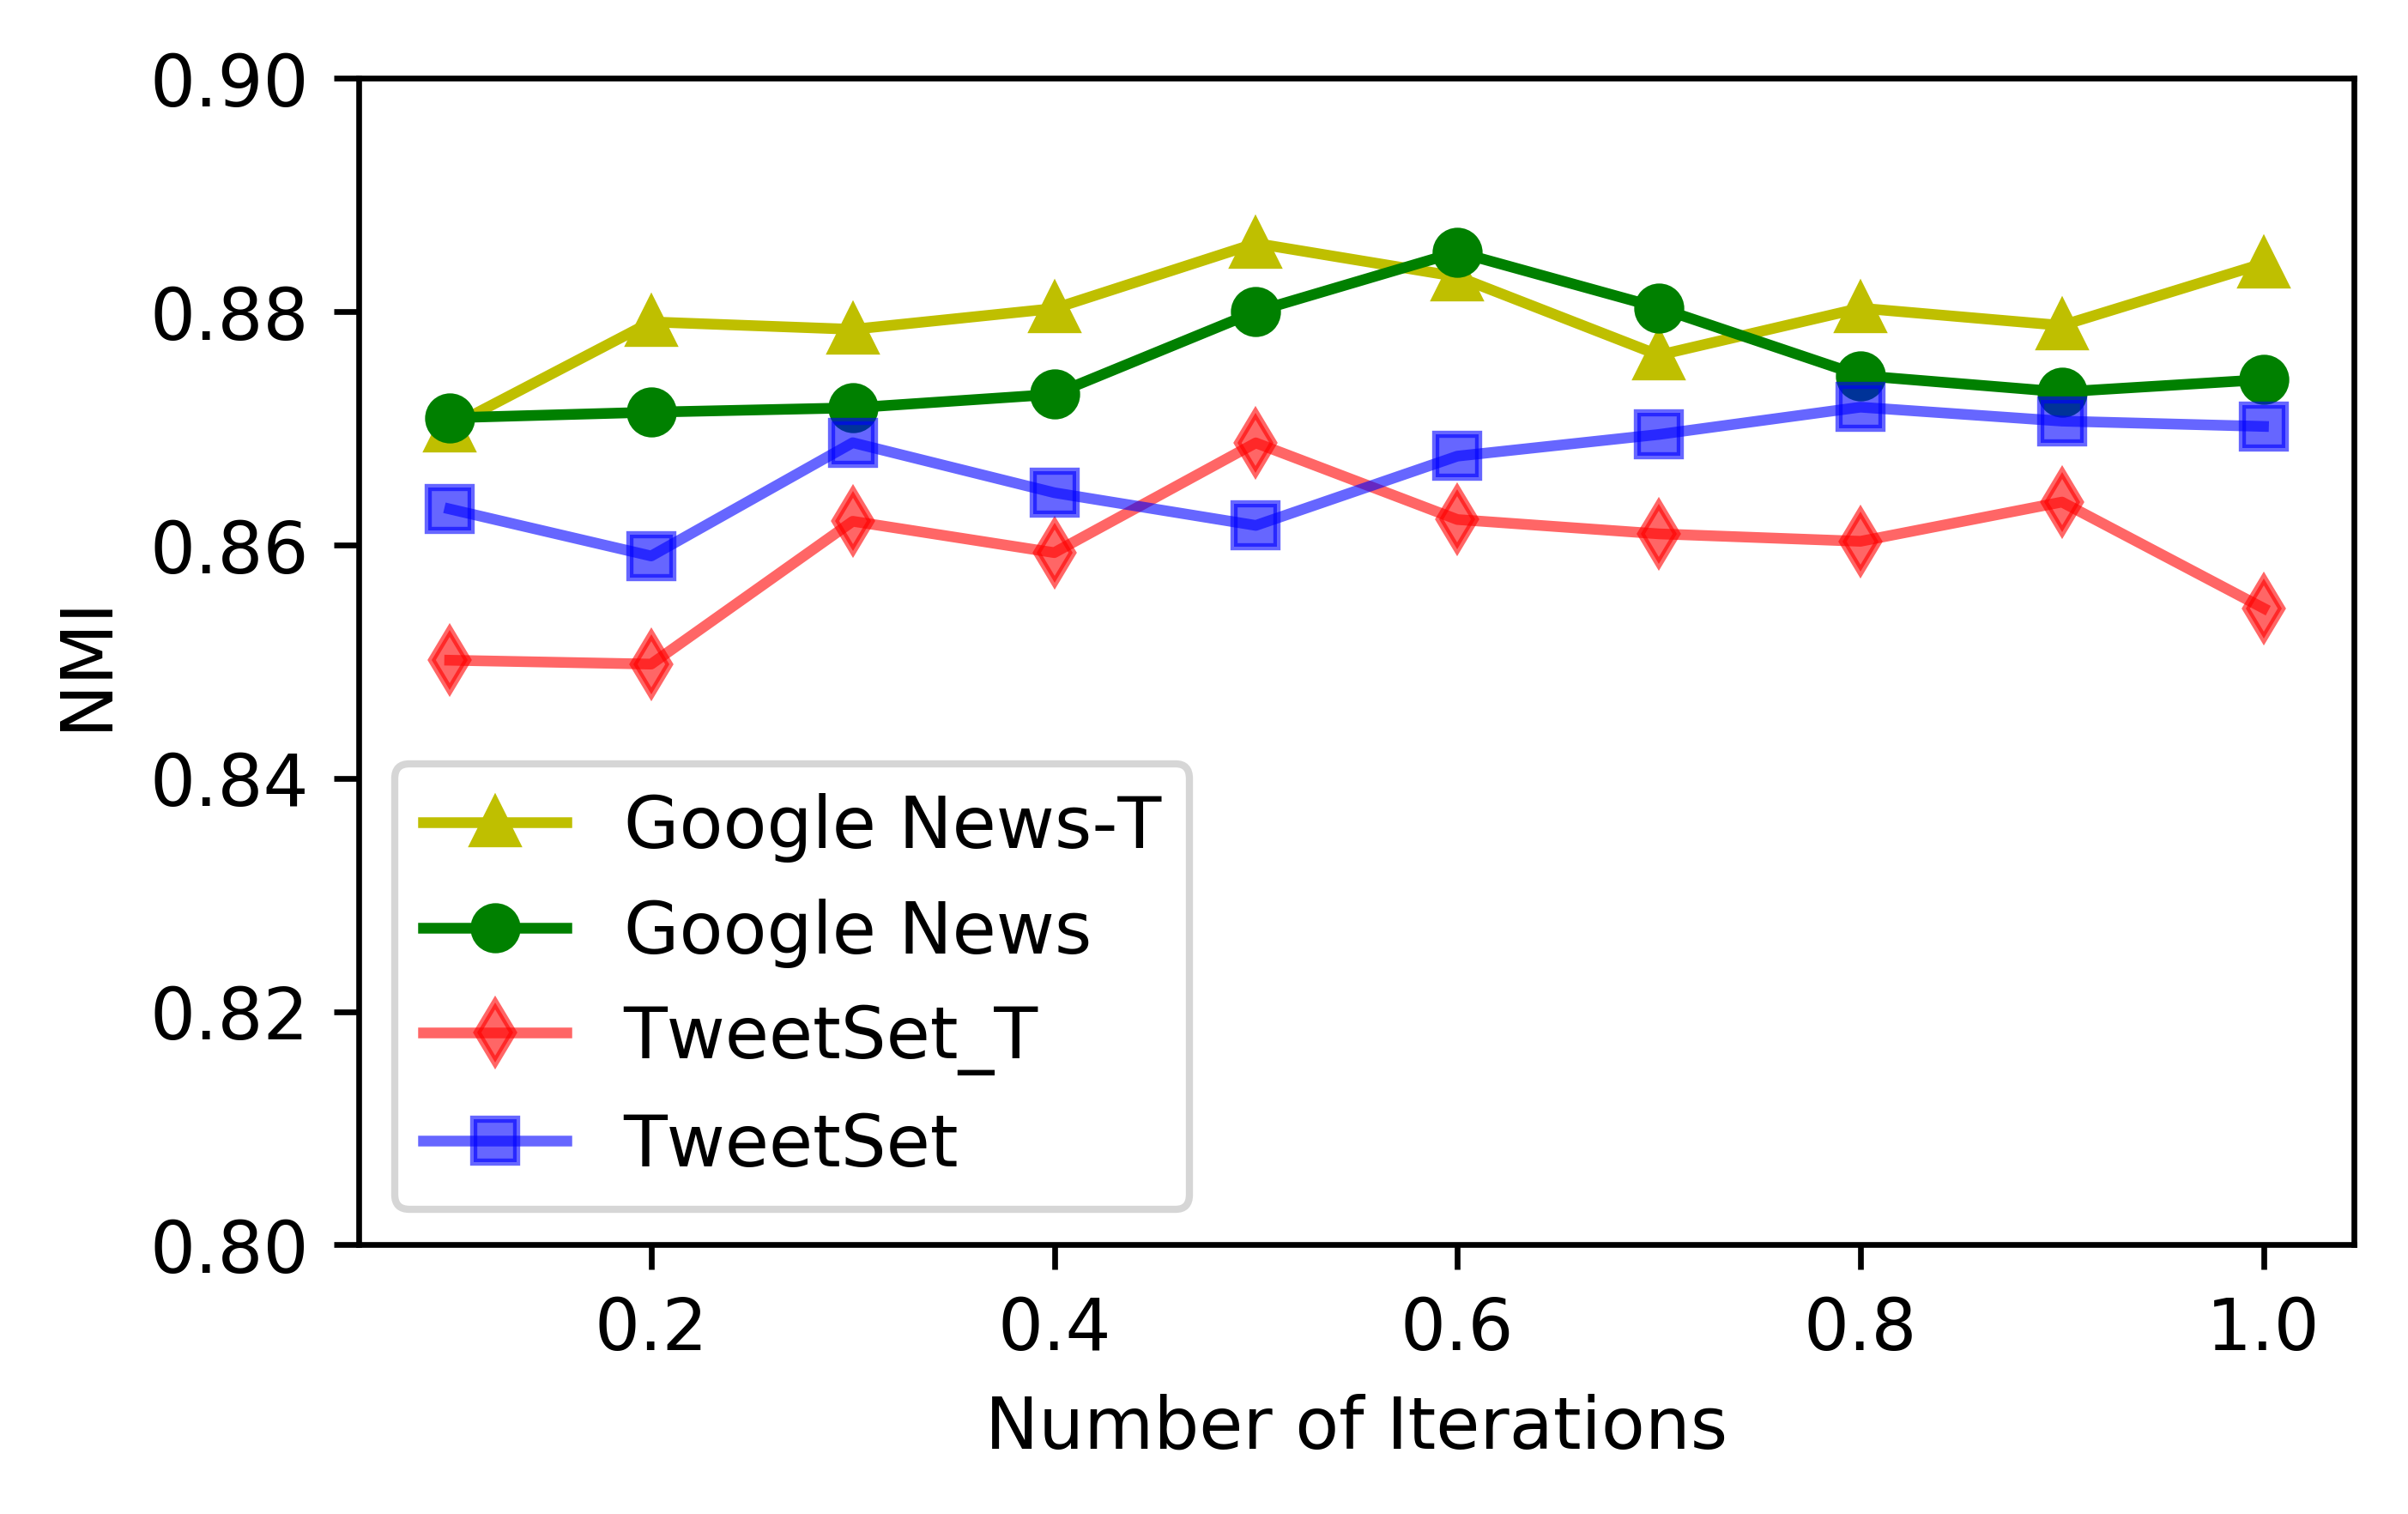

In [21]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

news_T = [0.8701064628011743, 0.8791220703267416, 0.8784863576750682, 0.8802691926562725, 0.8858562158225184, 0.8830048633869253, 0.8762745445213965, 0.8803015348929788, 0.8788164693242252, 0.884131464209089]
f = plt.figure(figsize=(5,3),dpi = 600)
#plt.plot(x, news_T, 'g', lw=1)
plt.plot( x , news_T, c= 'y',marker="^", alpha=1,label="Google News-T") 

news = [0.8709004907479806, 0.8713827312891201, 0.8717560496741923, 0.8729172708546922, 0.8800098678237721, 0.8851168898932172, 0.880337035664144, 0.8745213072455894, 0.8731187657555207, 0.8741759900927224]
#plt.plot(x, news, 'r', lw=1)
plt.plot( x,news, c= 'g',marker="o", alpha=1,label="Google News") 

tweets_T = [0.8501170790654703, 0.8497837365672808, 0.8620309059889932, 0.8593399509327505, 0.8687509693321654, 0.8621786577877947, 0.8609508039846049, 0.8603121225412141, 0.8636778677384508, 0.8545787607757205 ]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [0.8630841853405375, 0.8590541089822986, 0.8687674321235832, 0.8644798941318023, 0.861674271985366, 0.867613577256499, 0.8694736783205159, 0.8718119277938999, 0.8706175047674019, 0.8701634637462661]
#plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 

plt.xlabel("Number of Iterations")
plt.ylabel("NMI")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(0.8,0.9)
 
#显示图示
plt.legend()
 
#显示图
plt.show()

f.savefig("NMIandInterationNews.pdf", bbox_inches='tight')


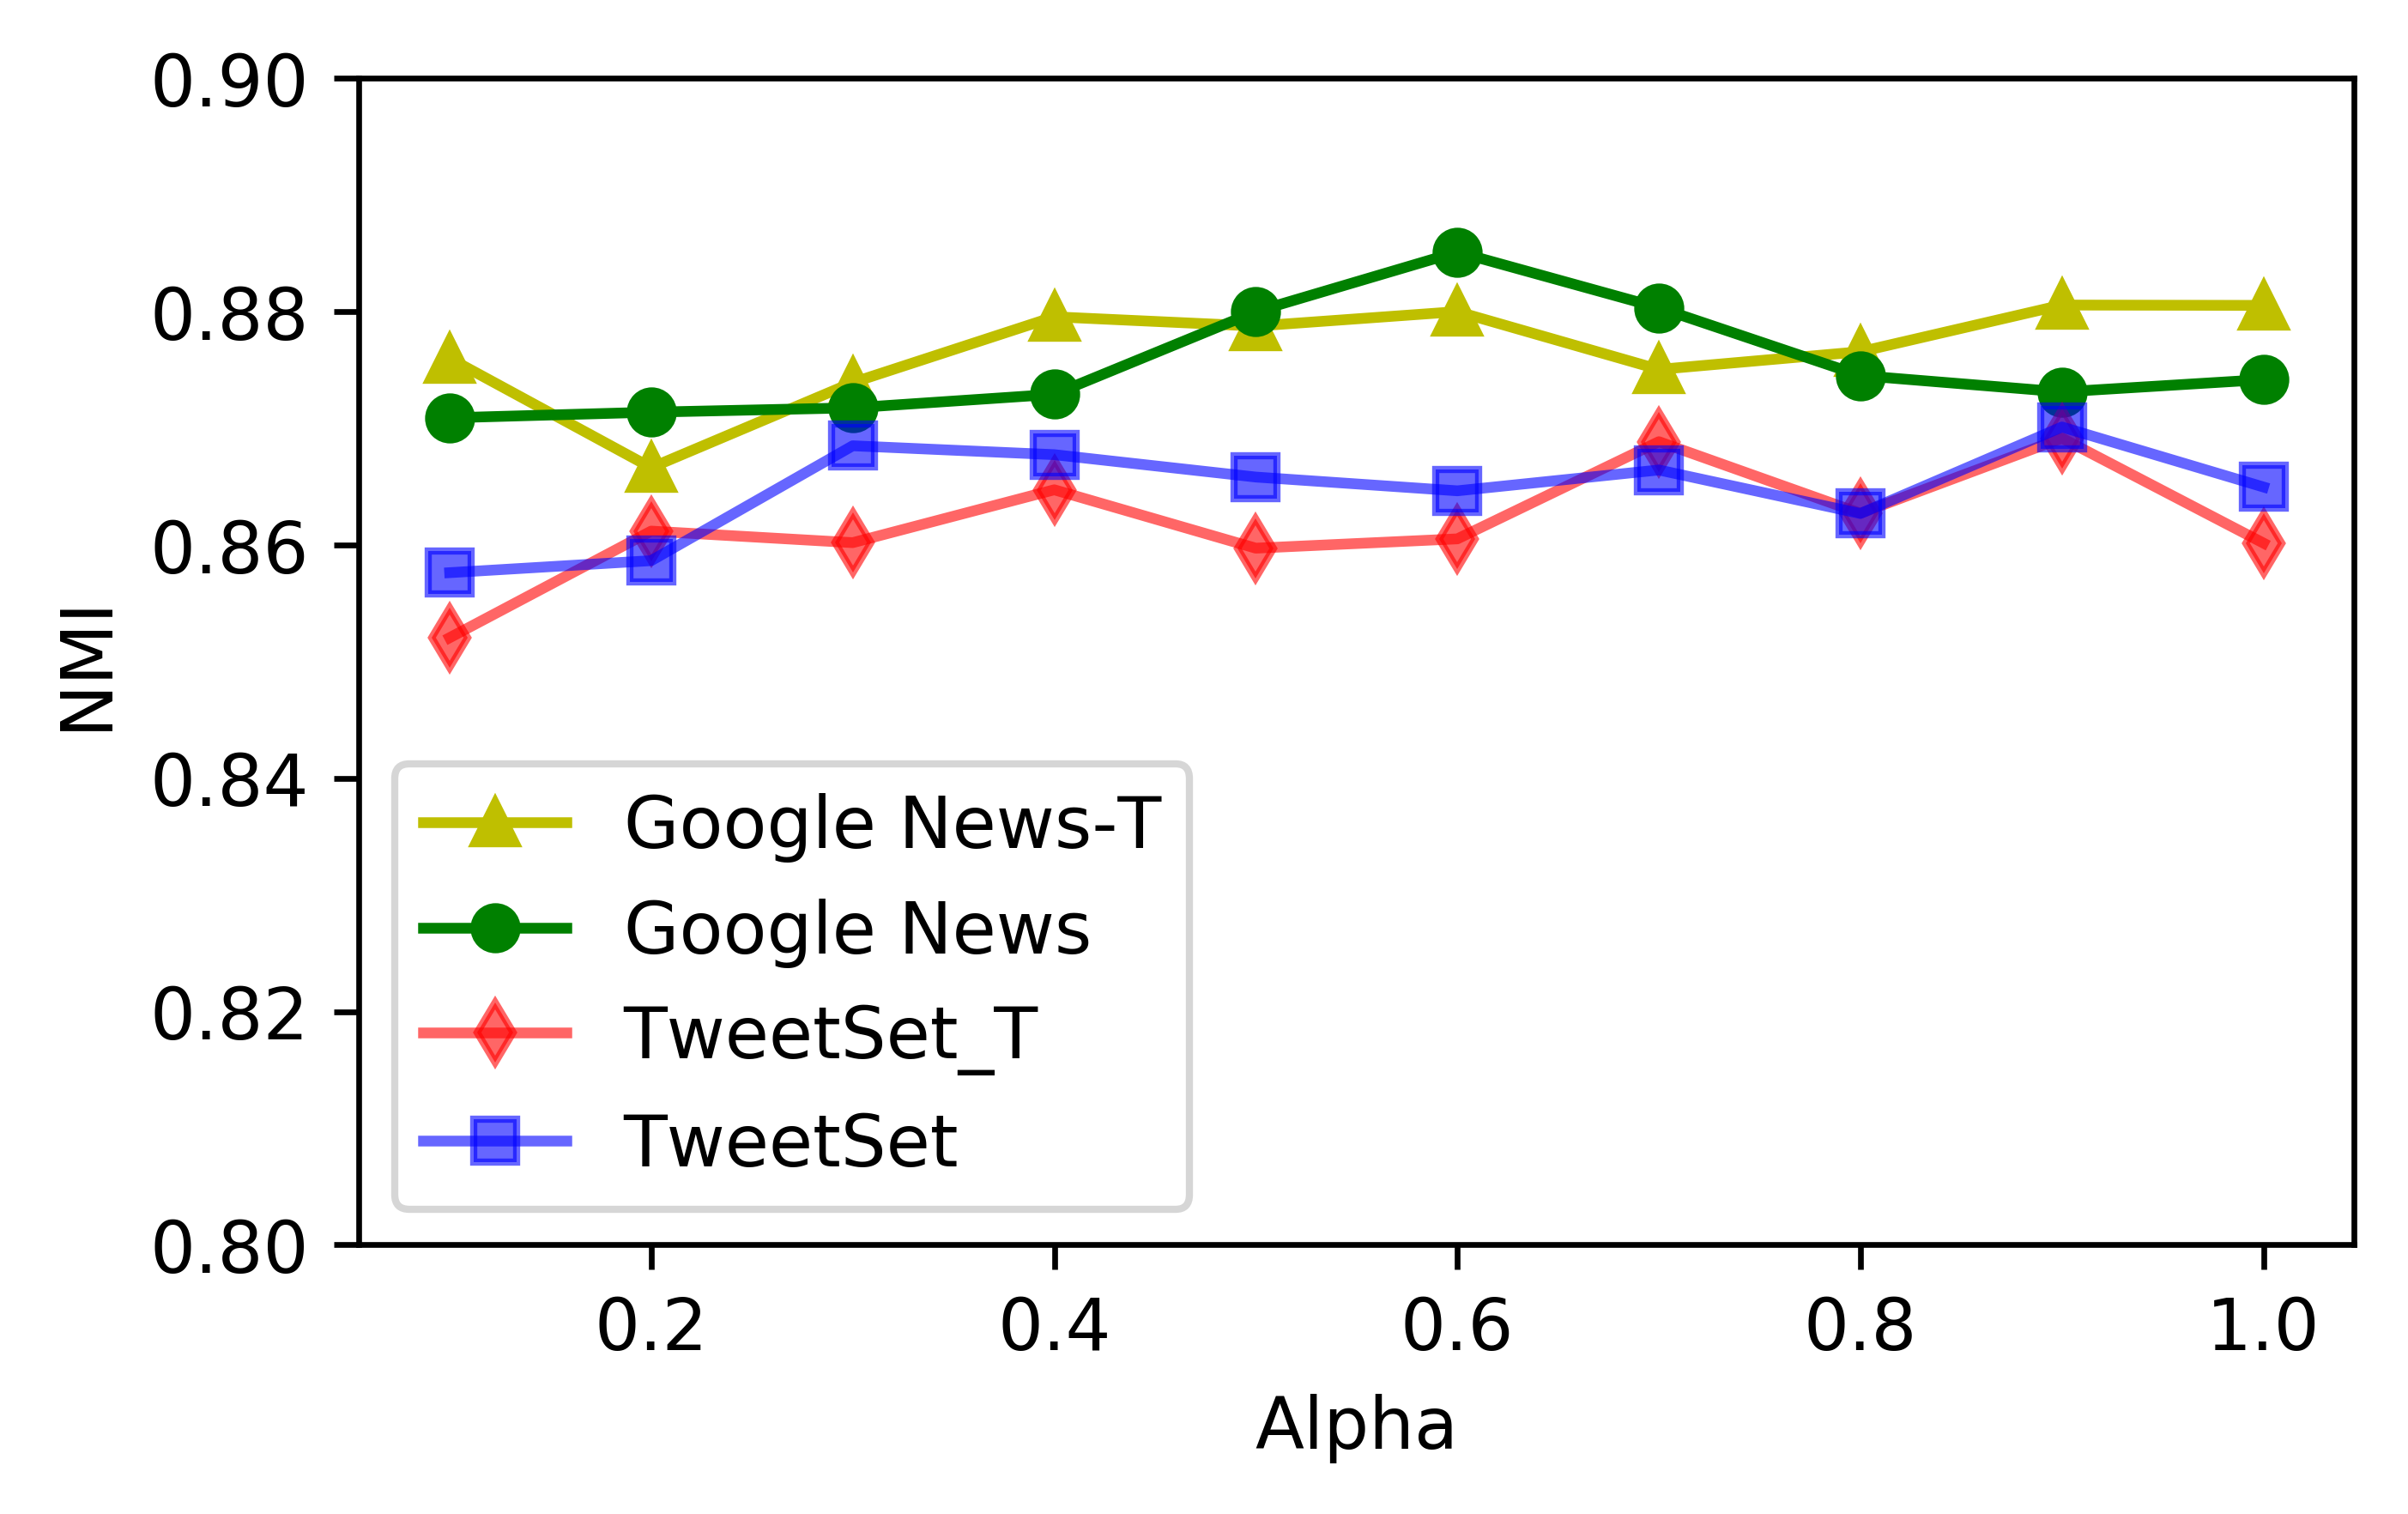

In [7]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

news_T = [0.8759991059420527, 0.8666254698988339, 0.8739217740560054, 0.8795605036889288, 0.8787647960722234, 0.8800039162103155, 0.8750504678460989, 0.8765663088915112, 0.8805671168934703, 0.8805383733481288]
f = plt.figure(figsize=(5,3),dpi = 600)
#plt.plot(x, news_T, 'g', lw=1)
plt.plot( x , news_T, c= 'y',marker="^", alpha=1,label="Google News-T") 

news = [0.8709004907479806, 0.8713827312891201, 0.8717560496741923, 0.8729172708546922, 0.8800098678237721, 0.8851168898932172, 0.880337035664144, 0.8745213072455894, 0.8731187657555207, 0.8741759900927224]
#plt.plot(x, news, 'r', lw=1)
plt.plot( x,news, c= 'g',marker="o", alpha=1,label="Google News") 

tweets_T = [0.8520483010919556, 0.8611880095257435, 0.8601959053702546, 0.8647294236569703, 0.8597235527764326, 0.8605213150684458, 0.8688556401625741, 0.8627139245182271, 0.8691550931922145, 0.8601577121181089]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [0.8576236526394919, 0.8586536011796755, 0.8685020369997749, 0.8677414369927499, 0.8658207499783499, 0.8646413267701765, 0.8664269125054374, 0.8626943522742703, 0.8701124326918831, 0.864967309899411]
#plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 

plt.xlabel("Alpha")
plt.ylabel("NMI")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(0.8,0.9)
 
#显示图示
plt.legend()
 
#显示图
plt.show()

f.savefig("./ijcai/NMIandAlpha.pdf", bbox_inches='tight')


In [23]:
print(alpha_topics.values())
print(alpha_topics.keys())

dict_values([120, 132, 139, 146, 168, 171, 168, 174, 168, 186])
dict_keys([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])


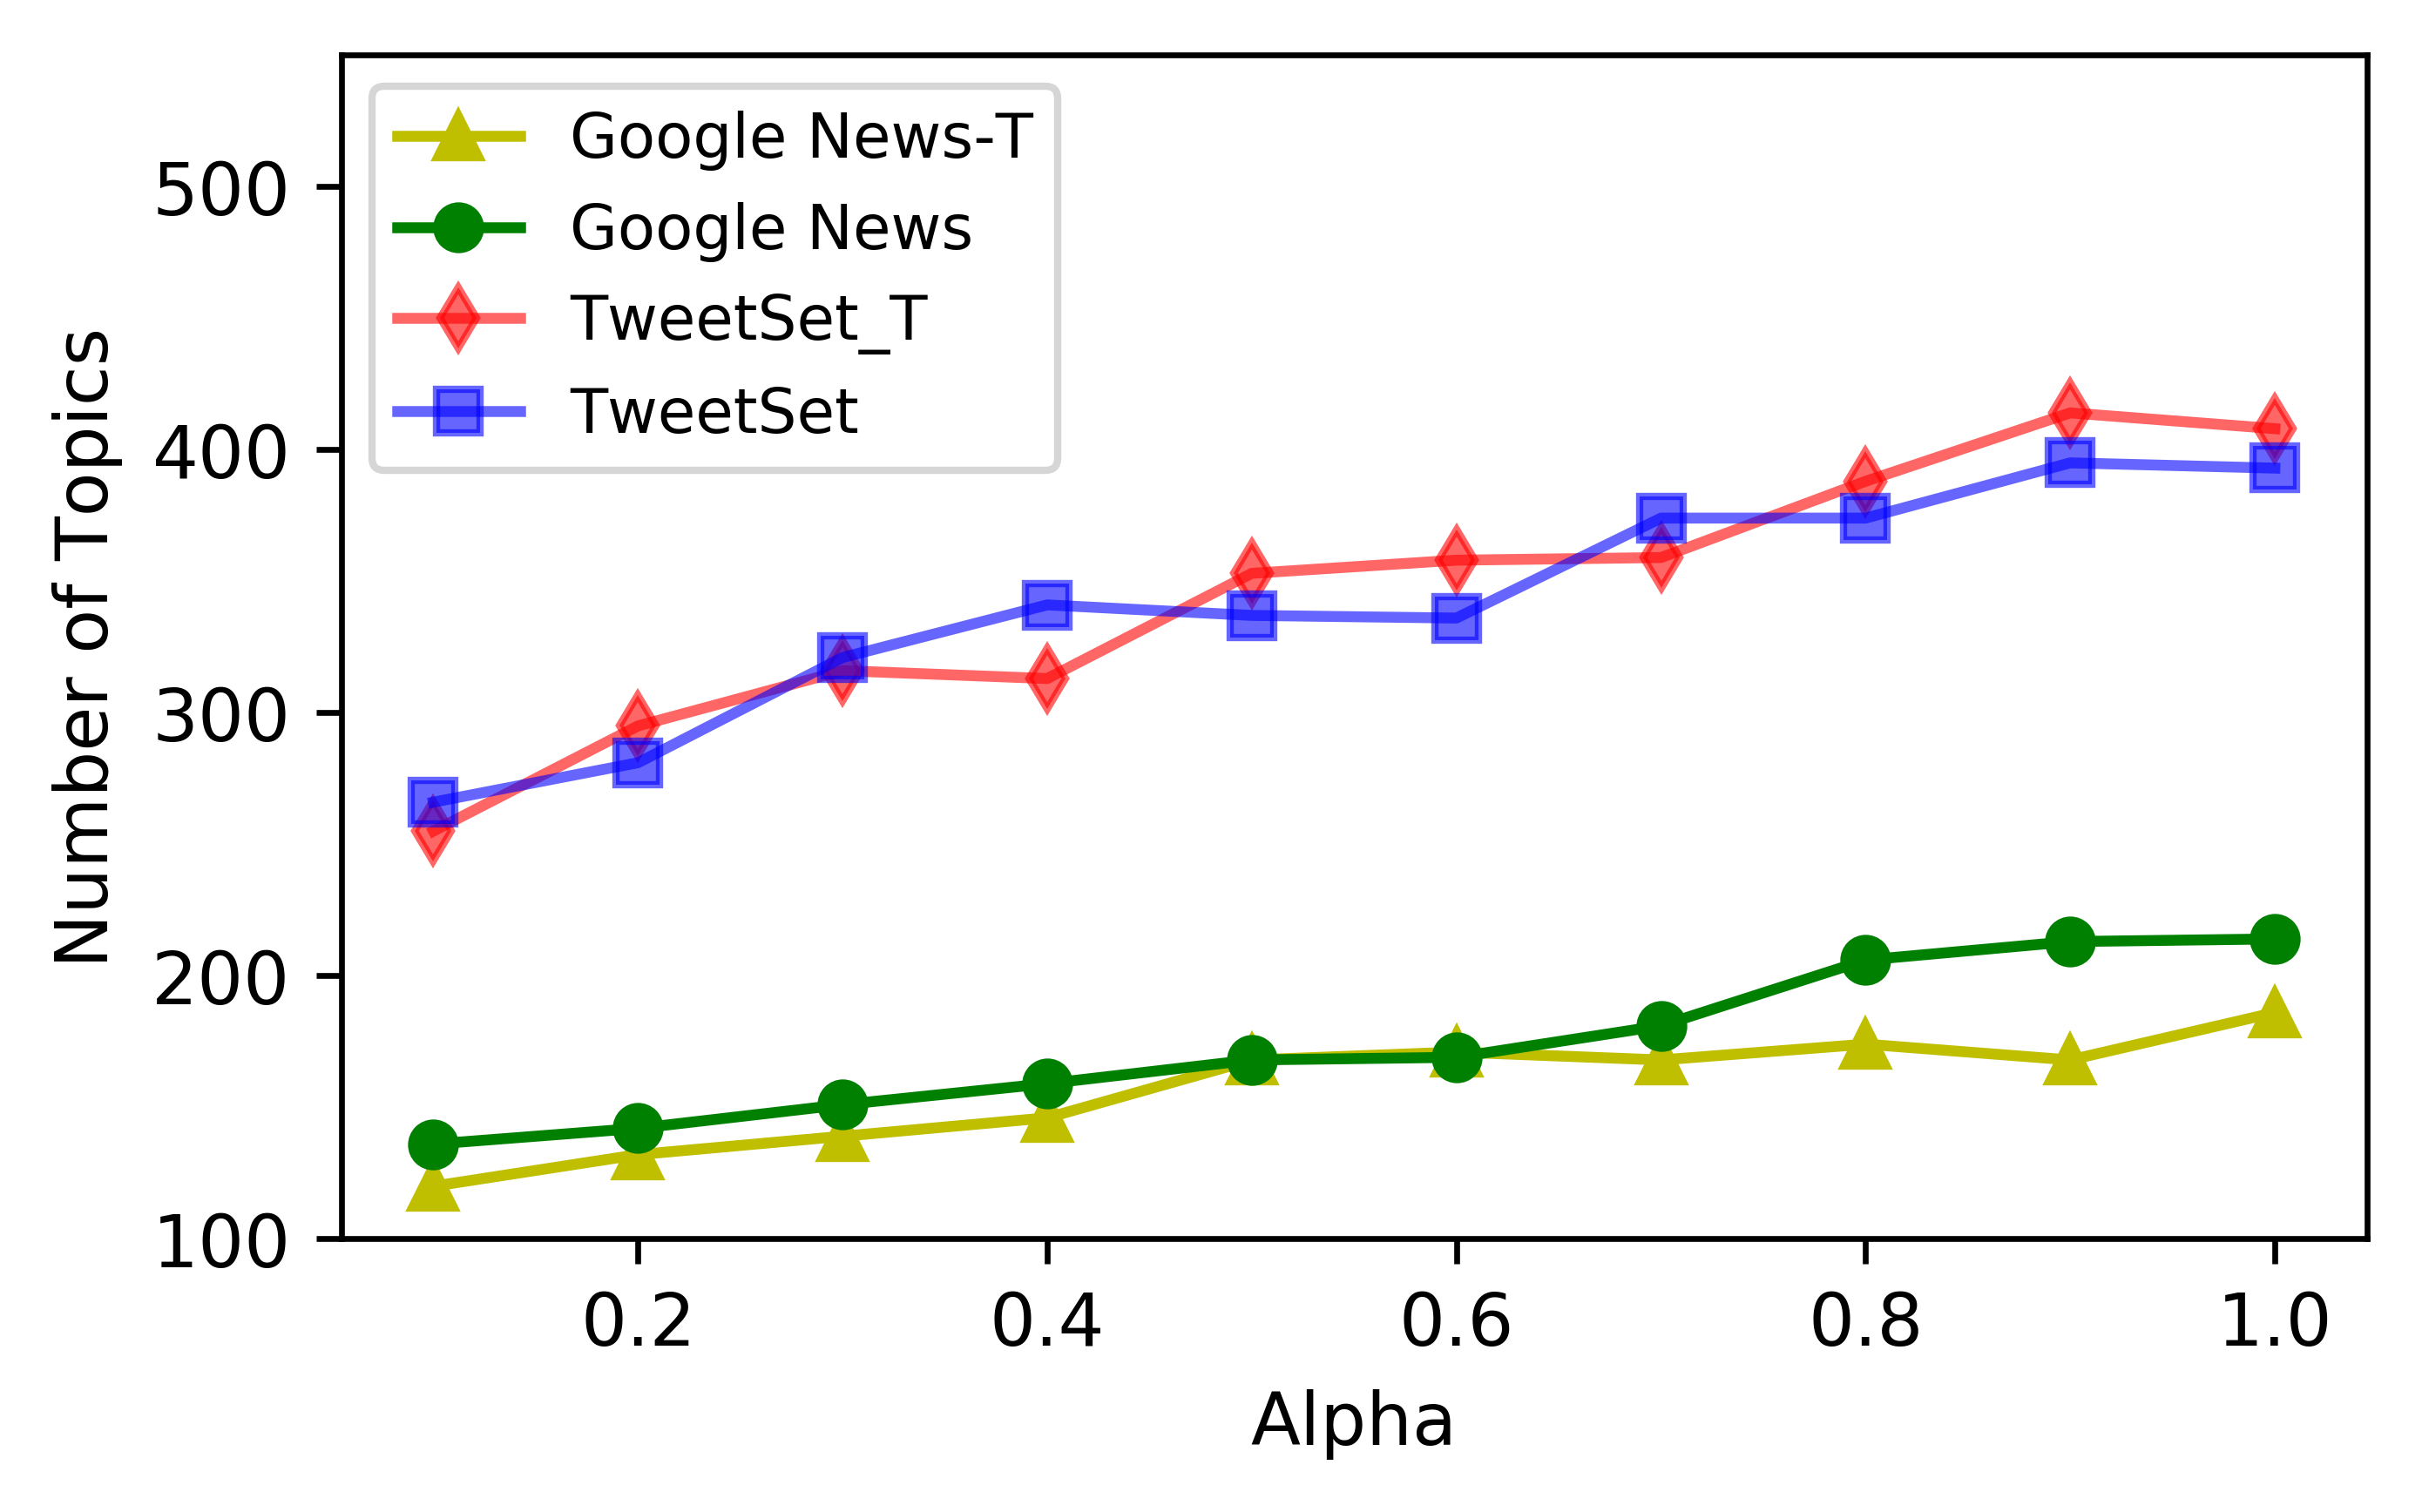

In [27]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

news_T = [120, 132, 139, 146, 168, 171, 168, 174, 168, 186]
f = plt.figure(figsize=(5,3),dpi = 600)
#plt.plot(x, news_T, 'g', lw=1)
plt.plot( x , news_T, c= 'y',marker="^", alpha=1,label="Google News-T") 

news = [136, 142, 151, 159, 168, 169, 181, 206, 213, 214]
#plt.plot(x, news, 'r', lw=1)
plt.plot( x,news, c= 'g',marker="o", alpha=1,label="Google News") 

tweets_T = [255, 295, 316, 313, 353, 358, 359, 388, 414, 408]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [266, 281, 321, 341, 337, 336, 374, 374, 395, 393]
#plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 

plt.xlabel("Alpha")
plt.ylabel("Number of Topics")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(100,550)
 
#显示图示
plt.legend( prop={'size': 8.5})
 
#显示图
plt.show()

f.savefig("./ijcai/NMIandAlpha.pdf", bbox_inches='tight')


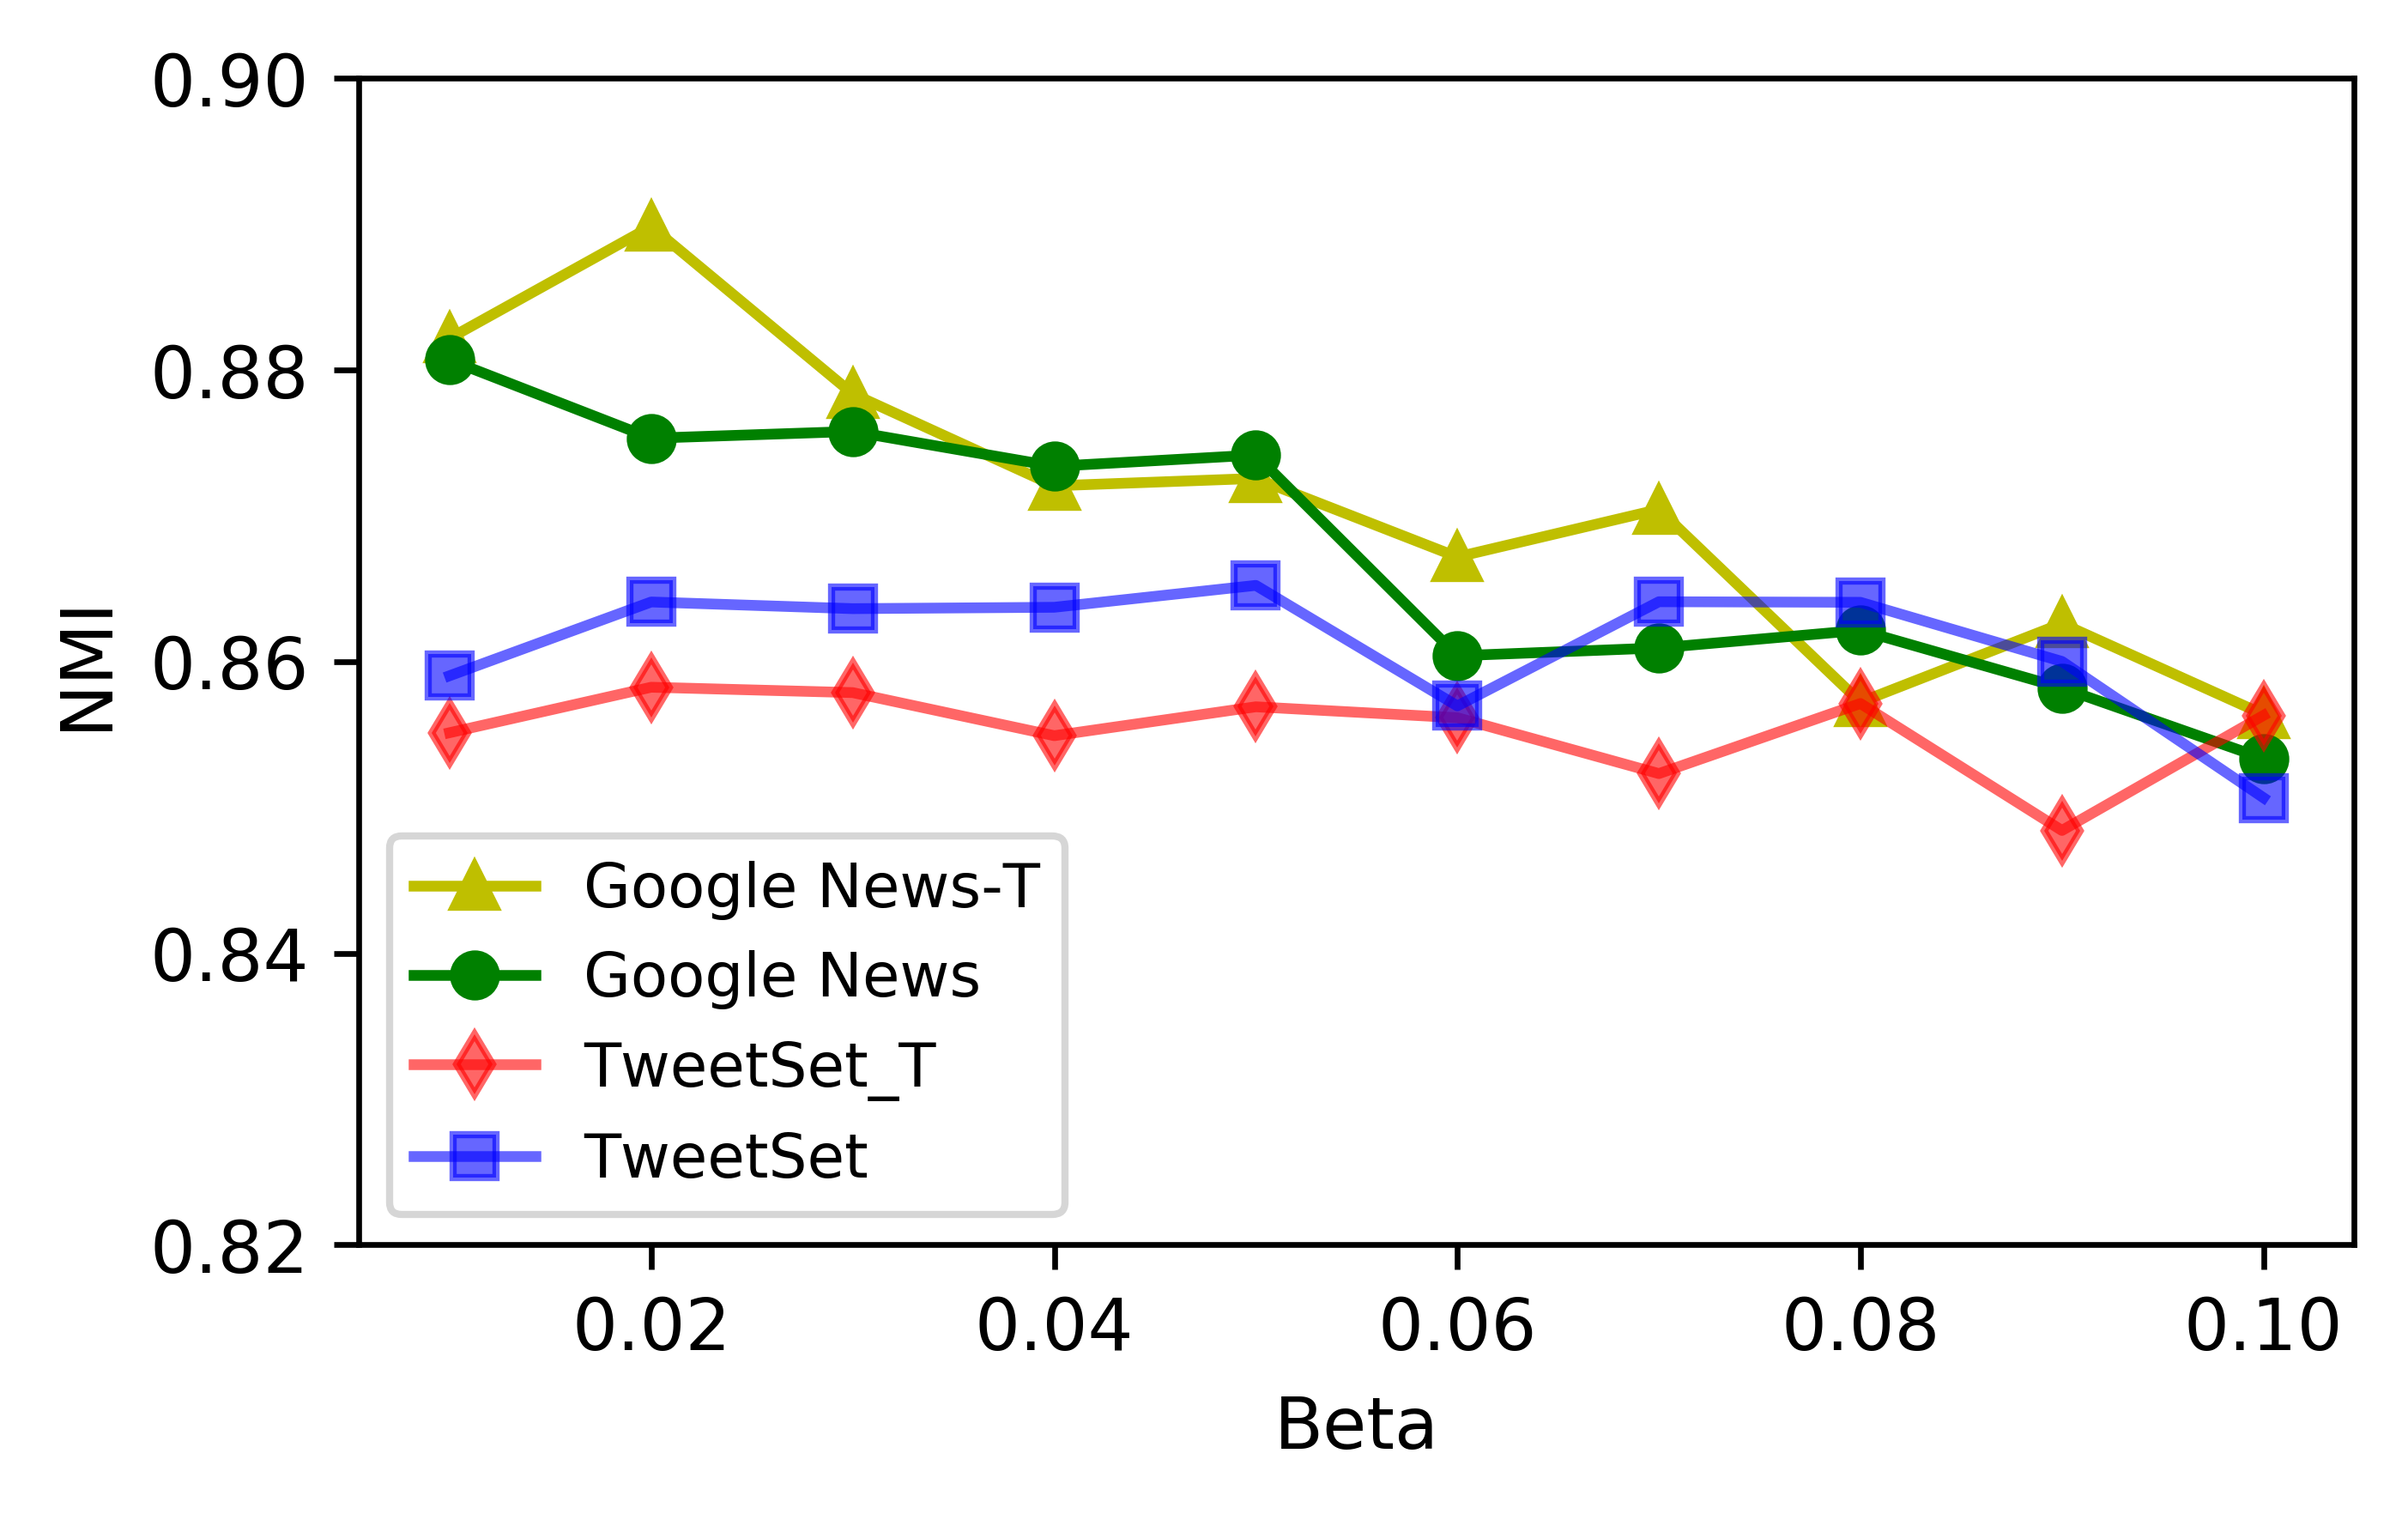

In [25]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

news_T = [0.8821747866754197, 0.8898429263054367, 0.8783648367185972, 0.8720566875817454, 0.8725618757554926, 0.8671761269866013, 0.8704358913653603, 0.8572194343494399, 0.8626100627486804, 0.8563767268418623]
f = plt.figure(figsize=(5,3),dpi = 600)
#plt.plot(x, news_T, 'g', lw=1)
plt.plot( x , news_T, c= 'y',marker="^", alpha=1,label="Google News-T") 

news = [0.880686687615661, 0.8753218020382275, 0.8757848634782651, 0.873392153451007, 0.8741693241490637, 0.8604000162995704, 0.8609364264057996, 0.862148394531424, 0.8581932773272566, 0.8533496044461678]
#plt.plot(x, news, 'r', lw=1)
plt.plot( x,news, c= 'g',marker="o", alpha=1,label="Google News") 

tweets_T = [0.8551235444305585, 0.8582414875132093, 0.8578724076184829, 0.8549176056146927, 0.8568998049707611, 0.8561507198902963, 0.8523177183269481, 0.8571254744226016, 0.8484178240176261, 0.8563080891556217]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [0.8590309209660445, 0.864088714987222, 0.8636305784543777, 0.8637251554130506, 0.8652263915169635, 0.8569609183274789, 0.8641053131039257, 0.8640664751412256, 0.8600098566957931, 0.8506597272175959]
#plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 

plt.xlabel("Beta")
plt.ylabel("NMI")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(0.82,0.9)
 
#显示图示
plt.legend(loc = "lower left", prop={'size': 8.5})
 
#显示图
plt.show()

f.savefig("./ijcai/NMIandAlpha.pdf", bbox_inches='tight')


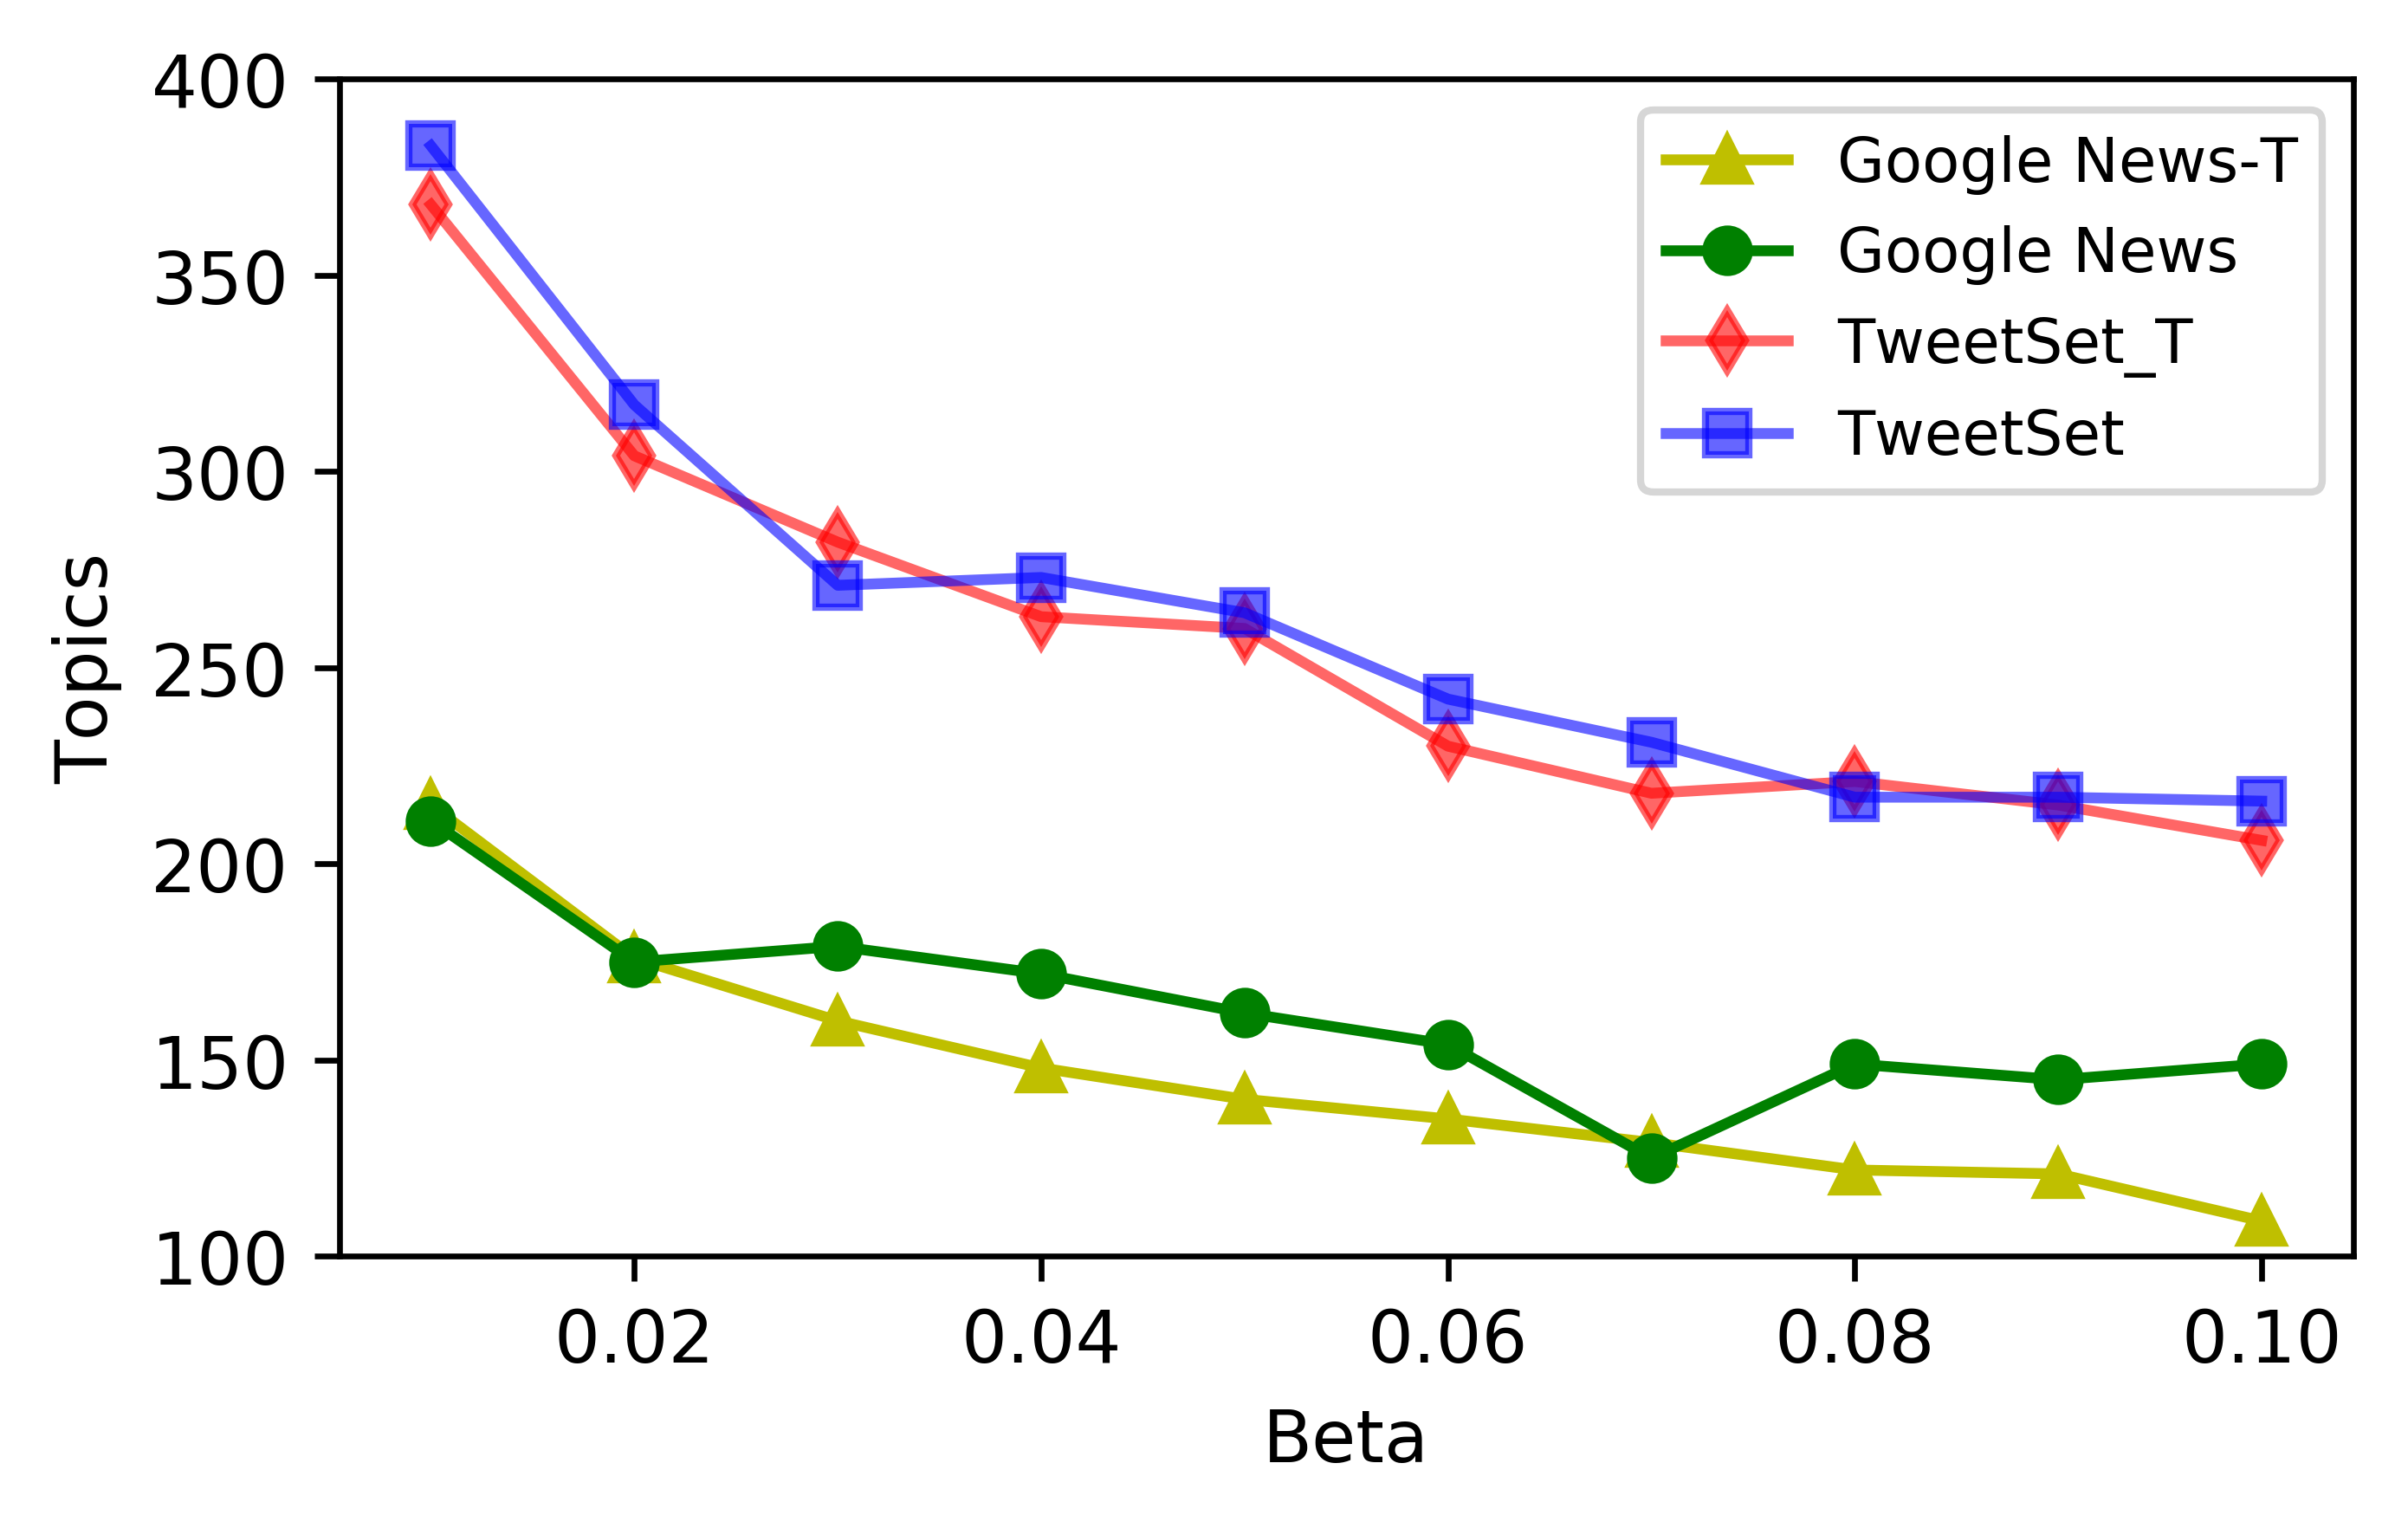

In [26]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

news_T = [215, 176, 160, 148, 140, 135, 129, 122, 121, 109]
f = plt.figure(figsize=(5,3),dpi = 600)
#plt.plot(x, news_T, 'g', lw=1)
plt.plot( x , news_T, c= 'y',marker="^", alpha=1,label="Google News-T") 

news = [211, 175, 179, 172, 162, 154, 125, 149, 145, 149]
#plt.plot(x, news, 'r', lw=1)
plt.plot( x,news, c= 'g',marker="o", alpha=1,label="Google News") 

tweets_T = [368, 304, 282, 263, 260, 230, 218, 221, 215, 206]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [383, 317, 271, 273, 264, 242, 231, 217, 217, 216]
#plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 

plt.xlabel("Beta")
plt.ylabel("Topics")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(100,400)
 
#显示图示
plt.legend(prop={'size': 8.5})
#显示图
plt.show()

f.savefig("NMIandInterationNews.pdf", bbox_inches='tight')
